In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline

In [2]:
df = pd.read_pickle("./shows_df_final.pkl")

In [3]:
df.head()

,link,imdb_rating,title,s01_episodes,avg_runtime,genres,rel_date,certification,origin,creators,creators_a,stars,stars_a
0,https://www.imdb.com/title/tt7670568,5.8,The Masked Singer,10,60,"[Game-Show, Music, Reality-TV]",2019-01-02,TV-PG,United States,[],[],"[Jenny McCarthy-Wahlberg, Ken Jeong, Nicole Sc...","[3, 5, 1]"
1,https://www.imdb.com/title/tt8001250,6.2,Siempre Bruja,11,40,"[Drama, Fantasy]",2019-01-01,TV-14,Colombia,[],[],"[Sofía Araujo Mejía, Angely Gaviria, Sofía Ara...","[0, 0, 0]"
2,https://www.imdb.com/title/tt8115560,6.6,Tidying Up with Marie Kondo,8,40,[Reality-TV],2019-01-01,TV-PG,United States,[Marie Kondo],[1],"[Marie Kondo, Charlotte Hervieux, Marie Iida]","[1, 0, 0]"
3,https://www.imdb.com/title/tt8324422,8.0,PEN15,10,30,[Comedy],2019-02-08,TV-MA,United States,"[Anna Konkle, Maya Erskine, Sam Zvibleman]","[1, 1, 4]","[Maya Erskine, Anna Konkle, Melora Walters]","[1, 1, 5]"
4,https://www.imdb.com/title/tt8888322,6.6,Bloom,6,60,"[Drama, Mystery, Sci-Fi]",2019-01-01,,Australia,[Glen Dolman],[5],"[Bryan Brown, Phoebe Tonkin, Genevieve Morris]","[11, 0, 1]"


# DATA CLEANING, PREPARATION AND INITIAL EXPLORATIONS

GENRES

In [4]:
genres_l = set(df.genres.sum())

In [5]:
def m(x):
    if i in x:
        return 1
    else:
        return 0
    
for i in genres_l:
    df[i] = df.genres.apply(m)

In [24]:
df[['imdb_rating'] + list(genres_l)].corr().iloc[:,0]

KeyError: "['Talk-Show', 'Game-Show', 'Reality-TV', 'Sci-Fi'] not in index"

In [23]:
df.rename(columns={"Talk-Show": "Talk_Show", "Sci-Fi": "Sci_Fi", "Game-Show": "Game_Show", "Reality-TV":"Reality_TV"}, inplace=True)

RELEASE DATE

In [8]:
df['rel_month']= pd.DatetimeIndex(df['rel_date']).month #creating release month column

CERTIFICATION

In [9]:
#after exploration looks like over 457 of the shows have no certification info, still will keep that column to anlyse shows that have certification info
df['certification'][df.certification.apply(len)>7] = "0"
df['certification'][df.certification==''] = "0"

#unification of the certification
df['certification'][df.certification=='TV-Y7'] = "TV-PG"
df['certification'][df.certification=='TV-G'] = "TV-PG"
df['certification'][df.certification=='TV-Y'] = "TV-PG"
df['certification'][df.certification=='PG'] = "TV-PG"
df['certification'][df.certification=='PG-13'] = "TV-14"

df.certification.value_counts()

/var/folders/vr/n5366ypx2jd2xjt2gj07clnh0000gn/T/ipykernel_25534/1279704069.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['certification'][df.certification.apply(len)>7] = "0"
/var/folders/vr/n5366ypx2jd2xjt2gj07clnh0000gn/T/ipykernel_25534/1279704069.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['certification'][df.certification==''] = "0"
/var/folders/vr/n5366ypx2jd2xjt2gj07clnh0000gn/T/ipykernel_25534/1279704069.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

0        457
TV-MA    446
TV-14    312
TV-PG    136
Name: certification, dtype: int64

In [10]:
df['TV_PG'] = (df['certification'] == 'TV-PG').apply(int)
df['TV_14'] = (df['certification'] == 'TV-14').apply(int)
df['TV_MA'] = (df['certification'] == 'TV-MA').apply(int)

ORIGIN

In [11]:
df.origin.value_counts()
# I will simplyfy that column to boolean 'made_in_usa'

United States             516
India                     159
United Kingdom            132
Japan                      84
South Korea                82
Turkey                     63
Spain                      28
Sweden                     20
Canada                     19
Italy                      17
Australia                  17
China                      17
France                     17
Norway                     15
Thailand                   14
Iran                       14
Serbia                     12
Germany                    12
Mexico                     12
Denmark                    11
Brazil                     10
Pakistan                    7
Egypt                       5
Taiwan                      5
Ireland                     5
South Africa                4
Russia                      4
Israel                      4
Belgium                     3
New Zealand                 3
Bangladesh                  3
Colombia                    3
Poland                      3
Netherland

In [12]:
df['made_in_usa'] = (df.origin == 'United States').apply(int)

In [13]:
df[['imdb_rating', 'made_in_usa']].corr()

,imdb_rating,made_in_usa
imdb_rating,1.000000,-0.165782
made_in_usa,-0.165782,1.000000


AWARDS

In [14]:
df['creators_a_n']= df.creators_a.apply(sum) #counting awards for creators, stars and sum of them
df['stars_a_n']= df.stars_a.apply(sum)
df['awards_n'] = df['creators_a_n'] + df['stars_a_n']

df.head()

,link,imdb_rating,title,s01_episodes,avg_runtime,genres,rel_date,certification,origin,creators,...,News,Fantasy,rel_month,TV_PG,TV_14,TV_MA,made_in_usa,creators_a_n,stars_a_n,awards_n
0,https://www.imdb.com/title/tt7670568,5.8,The Masked Singer,10,60,"[Game-Show, Music, Reality-TV]",2019-01-02,TV-PG,United States,[],...,0,0,1,1,0,0,1,0,9,9
1,https://www.imdb.com/title/tt8001250,6.2,Siempre Bruja,11,40,"[Drama, Fantasy]",2019-01-01,TV-14,Colombia,[],...,0,1,1,0,1,0,0,0,0,0
2,https://www.imdb.com/title/tt8115560,6.6,Tidying Up with Marie Kondo,8,40,[Reality-TV],2019-01-01,TV-PG,United States,[Marie Kondo],...,0,0,1,1,0,0,1,1,1,2
3,https://www.imdb.com/title/tt8324422,8.0,PEN15,10,30,[Comedy],2019-02-08,TV-MA,United States,"[Anna Konkle, Maya Erskine, Sam Zvibleman]",...,0,0,2,0,0,1,1,6,7,13
4,https://www.imdb.com/title/tt8888322,6.6,Bloom,6,60,"[Drama, Mystery, Sci-Fi]",2019-01-01,0,Australia,[Glen Dolman],...,0,0,1,0,0,0,0,5,12,17


In [25]:
df.corr().iloc[:1]

,imdb_rating,s01_episodes,avg_runtime,Horror,War,Romance,Short,Mystery,Crime,Talk_Show,...,News,Fantasy,rel_month,TV_PG,TV_14,TV_MA,made_in_usa,creators_a_n,stars_a_n,awards_n
imdb_rating,1.0,0.040933,0.073512,-0.099628,0.014655,0.043632,-0.056626,-0.001192,0.039858,-0.002762,...,0.068882,0.002337,0.029798,-0.111316,-0.025413,-0.034024,-0.165782,0.000685,0.058616,0.04947


In [16]:
(pd.Series((df.creators+df.stars).sum()).value_counts() > 3).sum() #it does not seem interesting to explore particular names as in explored time period only 12 artists manageged to work in more than 3 shows

12

# EDA, CHOOSING FEATURES FOR REGRESSION MODEL

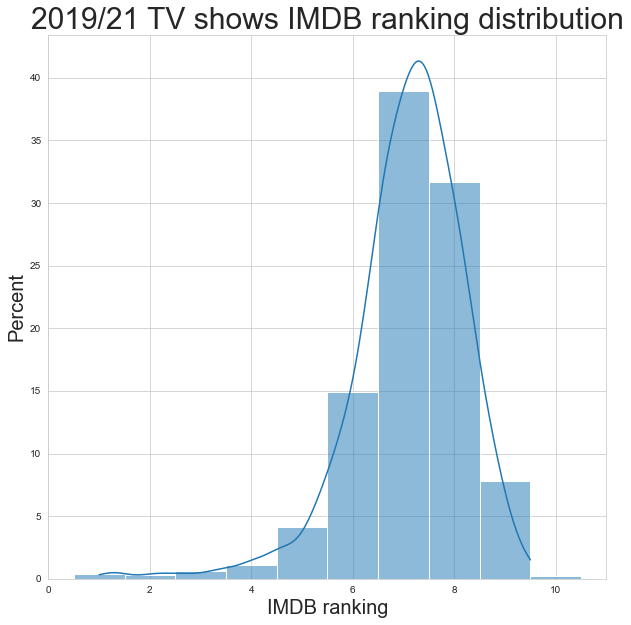

In [17]:
plt.figure(figsize = [10,10])
sns.set_style("whitegrid")
sns.histplot(df.imdb_rating, stat="percent", discrete=True, kde=True)
plt.title('2019/21 TV shows IMDB ranking distribution',  fontsize = 30)
plt.ylabel('Percent', fontsize = 20)
plt.xlabel('IMDB ranking', fontsize = 20)
plt.savefig('imdb_hist_plot', bbox_inches = 'tight');

In [66]:
x = df.corr().iloc[:,0]#checking correlations between taget and features
x = list(x[abs(x)>0.05].index)
x

['imdb_rating',
 'avg_runtime',
 'Horror',
 'Short',
 'Sport',
 'Biography',
 'Musical',
 'Reality_TV',
 'History',
 'Sci_Fi',
 'News',
 'TV_PG',
 'made_in_usa',
 'stars_a_n']

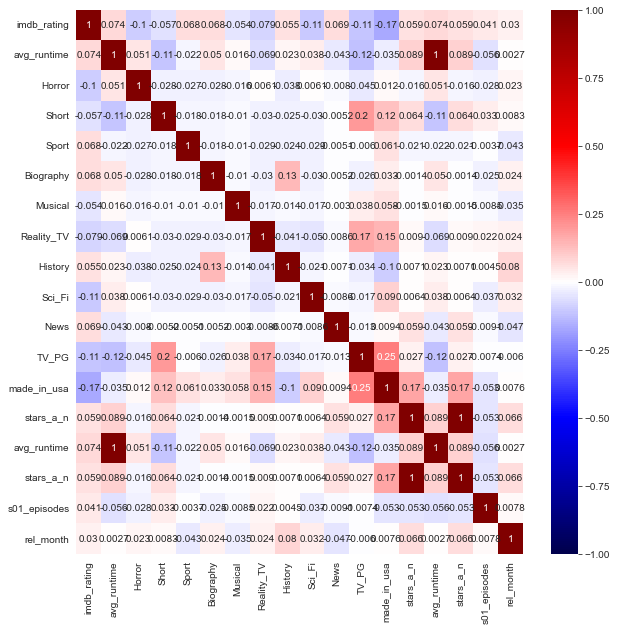

In [67]:
plt.figure(figsize = [10,10])
sns.heatmap(df[x + ['avg_runtime', 'stars_a_n', 's01_episodes', 'rel_month']].corr(), cmap="seismic", annot=True, vmin=-1, vmax=1)
plt.savefig('imdb_heat_map', bbox_inches = 'tight');

<Figure size 720x720 with 0 Axes>

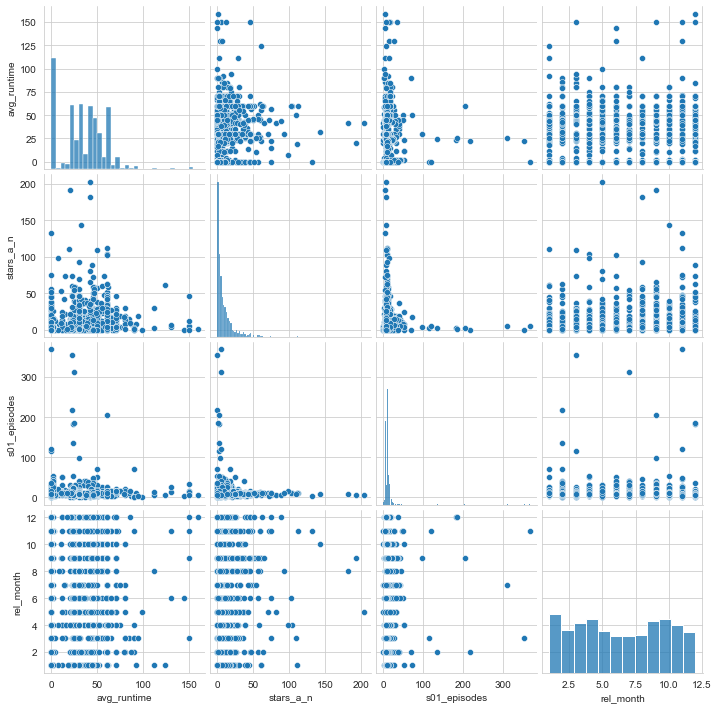

In [29]:
plt.figure(figsize = [10,10])
sns.pairplot(df[['avg_runtime', 'stars_a_n', 's01_episodes', 'rel_month']])
plt.savefig('imdb_pair_plot', bbox_inches = 'tight');

In [100]:
#y, X = patsy.dmatrices('imdb_rating ~  s01_episodes + avg_runtime + Horror + Romance + Short + Crime + Game_Show + Sport + Documentary + Biography + Musical + Western + Reality_TV + History + Family + Sci_Fi + Thriller+ Animation + News + TV_PG + TV_MA + made_in_usa + stars_a_n + awards_n', data=df, return_type="dataframe")
y = df.imdb_rating
X = df.drop(columns=['imdb_rating', 'link', 'title', 'genres', 'rel_date', 'certification', 'origin', 'creators', 'stars', 'creators_a', 'stars_a'], axis=1)
X = sm.add_constant(X).astype(float)

model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            imdb_rating   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     4.251
Date:                Thu, 07 Jul 2022   Prob (F-statistic):           5.94e-15
Time:                        20:25:28   Log-Likelihood:                -1995.3
No. Observations:                1351   AIC:                             4063.
Df Residuals:                    1315   BIC:                             4250.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            6.8532      0.126     54.327      0.000       6.606       7.101
s01_episodes     0.0021      0.001      1.445      0.149      -0.001       0.005
avg_runtime      0.0035      0.001      2.624      0.009       0.001       0.006
Horror          -0.4566      0.157     -2.903      0.004      -0.765      -0.148
War             -0.0102      0.373     -0.027      0.978      -0.742       0.722
Romance          0.0724      0.098      0.737      0.461      -0.120       0.265
Short           -0.3276      0.234     -1.399      0.162      -0.787       0.132
Mystery          0.0314      0.099      0.319      0.750      -0.162       0.225
Crime            0.1110      0.084      1.328      0.184      -0.053       0.275
Talk_Show       -0.3316      0.429     -0.772      0.440      -1.174       0.511
Game_Show       -0.0890      0.288     -0.309      0.757      -0.653       0.476
Sport            0.6656      0.233      2.857      0.004       0.209       1.123
Documentary      0.3418      0.148      2.316      0.021       0.052       0.631
Music            0.1394      0.221      0.630      0.529      -0.294       0.573
Biography        0.5114      0.231      2.217      0.027       0.059       0.964
Adventure        0.1528      0.117      1.311      0.190      -0.076       0.381
Comedy           0.2128      0.083      2.563      0.010       0.050       0.376
Action          -0.0388      0.095     -0.407      0.684      -0.226       0.148
Musical         -0.6472      0.385     -1.680      0.093      -1.403       0.109
Western          1.6241      1.084      1.498      0.134      -0.503       3.751
Reality_TV      -0.0197      0.175     -0.113      0.910      -0.362       0.323
History          0.2124      0.177      1.200      0.230      -0.135       0.560
Family          -0.1339      0.230     -0.581      0.561      -0.586       0.318
Sci_Fi          -0.3845      0.144     -2.667      0.008      -0.667      -0.102
Thriller         0.1050      0.105      1.004      0.316      -0.100       0.310
Animation        0.3468      0.114      3.046      0.002       0.123       0.570
Drama            0.0922      0.078      1.182      0.237      -0.061       0.245
News             2.2124      0.793      2.790      0.005       0.657       3.768
Fantasy          0.1331      0.121      1.100      0.272      -0.104       0.370
rel_month        0.0096      0.008      1.142      0.254      -0.007       0.026
TV_PG           -0.3708      0.129     -2.881      0.004      -0.623      -0.118
TV_14           -0.1795      0.092     -1.958      0.050      -0.359       0.000
TV_MA           -0.1707      0.084     -2.022      0.043      -0.336      -0.005
made_in_usa     -0.2925      0.076     -3.838      0.000      -0.442      -0.143
creators_a_n    -0.0003      0.003     -0.115      0.909      -0.006       0.005
stars

In [101]:
drop_col = ['imdb_rating', 'link', 'title', 'genres', 'rel_date', 'certification', 'origin', 'creators', 'stars', 'creators_a', 'stars_a', 'creators_a_n', 'awards_n', 's01_episodes', 'War', 'Reality_TV', 'Mystery']
y = df.imdb_rating
X = df.drop(columns=drop_col, axis=1)
X = sm.add_constant(X).astype(float)

model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            imdb_rating   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     4.887
Date:                Thu, 07 Jul 2022   Prob (F-statistic):           3.18e-16
Time:                        20:25:40   Log-Likelihood:                -1996.6
No. Observations:                1351   AIC:                             4055.
Df Residuals:                    1320   BIC:                             4217.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           6.8937      0.117     59.000      0.000       6.665       7.123
avg_runtime     0.0035      0.001      2.615      0.009       0.001       0.006
Horror         -0.4567      0.157     -2.914      0.004      -0.764      -0.149
Romance         0.0743      0.097      0.768      0.443      -0.116       0.264
Short          -0.3179      0.233     -1.366      0.172      -0.775       0.139
Crime           0.1099      0.081      1.351      0.177      -0.050       0.269
Talk_Show      -0.3093      0.428     -0.723      0.470      -1.149       0.530
Game_Show      -0.1184      0.265     -0.447      0.655      -0.637       0.401
Sport           0.6682      0.232      2.884      0.004       0.214       1.123
Documentary     0.3220      0.146      2.211      0.027       0.036       0.608
Music           0.1504      0.220      0.683      0.495      -0.281       0.582
Biography       0.5035      0.229      2.198      0.028       0.054       0.953
Adventure       0.1507      0.116      1.303      0.193      -0.076       0.377
Comedy          0.2096      0.079      2.665      0.008       0.055       0.364
Action         -0.0351      0.093     -0.378      0.705      -0.217       0.147
Musical        -0.6557      0.384     -1.706      0.088      -1.410       0.098
Western         1.6498      1.081      1.526      0.127      -0.471       3.770
History         0.2033      0.172      1.183      0.237      -0.134       0.540
Family         -0.1358      0.229     -0.592      0.554      -0.586       0.314
Sci_Fi         -0.3879      0.143     -2.711      0.007      -0.669      -0.107
Thriller        0.0931      0.103      0.904      0.366      -0.109       0.295
Animation       0.3424      0.112      3.063      0.002       0.123       0.562
Drama           0.0971      0.074      1.305      0.192      -0.049       0.243
News            2.1722      0.791      2.746      0.006       0.620       3.724
Fantasy         0.1352      0.120      1.127      0.260      -0.100       0.371
rel_month       0.0096      0.008      1.151      0.250      -0.007       0.026
TV_PG          -0.3833      0.127     -3.026      0.003      -0.632      -0.135
TV_14          -0.1865      0.091     -2.054      0.040      -0.365      -0.008
TV_MA          -0.1826      0.083     -2.195      0.028      -0.346      -0.019
made_in_usa    -0.2892      0.076     -3.807      0.000      -0.438      -0.140
stars_a_n       0.0049      0.002      2.837      0.005       0.002       0.008
==============================================================================
Omnibus:                      383.396   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1501.708
Skew:                          -1.321   Prob(JB):                         0.00
Kurtosis:                       7.438   Cond. N